# Tabular MLP Baseline
Use this notebook to train a feed-forward network with categorical embeddings on the AML transactions dataset. Adjust the configuration in Cell 2 before running subsequent cells.

In [1]:
from __future__ import annotations

import math
import json
from copy import deepcopy
from pathlib import Path
from types import SimpleNamespace
from typing import Any, Dict, Iterable, List, Tuple

import numpy as np
import pandas as pd
import torch
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset

CONFIG = {
    'dataset': 'dataset/HI-Small_Trans.csv',
    'epochs': 20,
    'batch_size': 8192,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'hidden_dims': '256,128,64',
    'dropout': 0.2,
    'test_size': 0.2,
    'val_size': 0.1,
    'random_state': 42,
    'base_embed_dim': 8,
    'max_embed_dim': 64,
    'device': 'auto',
    'target_fpr': 0.05,
    'report': None,
    'max_samples': None,
    'num_workers': 0,
}

cfg = SimpleNamespace(**CONFIG)

In [2]:
class TabularDataset(Dataset):
    def __init__(
        self,
        numeric: np.ndarray,
        categorical: np.ndarray,
        labels: np.ndarray,
    ) -> None:
        self.numeric = torch.tensor(numeric, dtype=torch.float32)
        self.categorical = torch.tensor(categorical, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self) -> int:
        return self.labels.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.numeric[idx], self.categorical[idx], self.labels[idx]


class TabularMLP(nn.Module):
    def __init__(
        self,
        num_numeric: int,
        categorical_cardinalities: List[int],
        hidden_dims: List[int],
        dropout: float,
        base_embed_dim: int,
        max_embed_dim: int,
    ) -> None:
        super().__init__()
        embeddings: List[nn.Module] = []
        embed_total = 0
        for cardinality in categorical_cardinalities:
            if cardinality <= 1:
                embeddings.append(None)  # type: ignore[arg-type]
                continue
            dim = min(max_embed_dim, max(4, int(math.ceil(cardinality ** 0.25 * base_embed_dim))))
            emb = nn.Embedding(cardinality, dim, padding_idx=0)
            nn.init.xavier_uniform_(emb.weight)
            embeddings.append(emb)
            embed_total += dim
        self.embeddings = nn.ModuleList([emb for emb in embeddings if emb is not None])
        self.embedding_indices = [idx for idx, emb in enumerate(embeddings) if emb is not None]

        input_dim = num_numeric + embed_total
        layers: List[nn.Module] = []
        prev_dim = input_dim
        for width in hidden_dims:
            layers.append(nn.Linear(prev_dim, width))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(width))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = width
        self.mlp = nn.Sequential(*layers) if layers else nn.Identity()
        self.head = nn.Linear(prev_dim, 1)

    def forward(self, numeric: torch.Tensor, categorical: torch.Tensor) -> torch.Tensor:
        pieces: List[torch.Tensor] = []
        if numeric.shape[1] > 0:
            pieces.append(numeric)
        if self.embeddings:
            embeds: List[torch.Tensor] = []
            for module, idx in zip(self.embeddings, self.embedding_indices):
                embeds.append(module(categorical[:, idx]))
            pieces.append(torch.cat(embeds, dim=1))
        features = pieces[0] if len(pieces) == 1 else torch.cat(pieces, dim=1)
        hidden = self.mlp(features) if isinstance(self.mlp, nn.Sequential) else self.mlp(features)
        return self.head(hidden).squeeze(dim=1)

In [3]:
def load_transactions(path: Path, max_samples: int | None) -> pd.DataFrame:
    df = pd.read_csv(path)
    if max_samples is not None and len(df) > max_samples:
        df = df.sample(max_samples, random_state=42).reset_index(drop=True)
    df = df.rename(
        columns={
            'From Bank': 'from_bank',
            'To Bank': 'to_bank',
            'Amount Received': 'amount_received',
            'Receiving Currency': 'receiving_currency',
            'Amount Paid': 'amount_paid',
            'Payment Currency': 'payment_currency',
            'Payment Format': 'payment_format',
            'Is Laundering': 'is_laundering',
        }
    )
    if 'Account' in df.columns:
        df = df.rename(columns={'Account': 'from_account'})
    if 'Account.1' in df.columns:
        df = df.rename(columns={'Account.1': 'to_account'})
    return df


def engineer_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    work = df.copy()
    work['timestamp'] = pd.to_datetime(work['Timestamp'], errors='coerce')

    work['hour'] = work['timestamp'].dt.hour.fillna(-1).astype(int)
    work['dayofweek'] = work['timestamp'].dt.dayofweek.fillna(-1).astype(int)
    work['month'] = work['timestamp'].dt.month.fillna(-1).astype(int)
    work['is_weekend'] = (work['dayofweek'] >= 5).astype(int)
    work['same_bank'] = (work['from_bank'] == work['to_bank']).astype(int)
    if 'from_account' in work.columns and 'to_account' in work.columns:
        work['same_account'] = (work['from_account'] == work['to_account']).astype(int)
    else:
        work['same_account'] = 0
    work['amount_diff'] = work['amount_received'] - work['amount_paid']
    work['amount_ratio'] = np.divide(
        work['amount_received'],
        work['amount_paid'],
        out=np.full(work.shape[0], np.nan, dtype=float),
        where=work['amount_paid'].abs() > 0,
    )
    work['amount_ratio'] = np.where(np.isfinite(work['amount_ratio']), work['amount_ratio'], np.nan)
    work['is_round_amount'] = ((work['amount_paid'] % 100) == 0).astype(int)

    feature_cols = [
        'amount_received',
        'amount_paid',
        'amount_diff',
        'amount_ratio',
        'hour',
        'dayofweek',
        'month',
        'is_weekend',
        'same_bank',
        'same_account',
        'is_round_amount',
        'from_bank',
        'to_bank',
        'receiving_currency',
        'payment_currency',
        'payment_format',
    ]
    return work[feature_cols], work['is_laundering'].astype(int)


def split_data(
    X: pd.DataFrame,
    y: pd.Series,
    test_size: float,
    val_size: float,
    random_state: int,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    X_tmp, X_test, y_tmp, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )
    relative_val = val_size / (1.0 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_tmp,
        y_tmp,
        test_size=relative_val,
        stratify=y_tmp,
        random_state=random_state + 1,
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


def prepare_categorical(
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    X_test: pd.DataFrame,
    categorical_cols: List[str],
) -> Tuple[Dict[str, Dict[str, int]], Dict[str, int], Dict[str, np.ndarray], Dict[str, np.ndarray], Dict[str, np.ndarray]]:
    mappings: Dict[str, Dict[str, int]] = {}
    cardinalities: Dict[str, int] = {}
    train_encoded: Dict[str, np.ndarray] = {}
    val_encoded: Dict[str, np.ndarray] = {}
    test_encoded: Dict[str, np.ndarray] = {}

    for col in categorical_cols:
        uniques = X_train[col].dropna().unique().tolist()
        mapping = {value: idx + 1 for idx, value in enumerate(uniques)}
        mappings[col] = mapping
        cardinalities[col] = len(mapping) + 1

        def encode(series: pd.Series) -> np.ndarray:
            coded = series.map(mapping).fillna(0).astype(np.int64)
            return coded.to_numpy()

        train_encoded[col] = encode(X_train[col])
        val_encoded[col] = encode(X_val[col])
        test_encoded[col] = encode(X_test[col])

    return mappings, cardinalities, train_encoded, val_encoded, test_encoded


def prepare_numeric(
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    X_test: pd.DataFrame,
    numeric_cols: List[str],
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    train_numeric = X_train[numeric_cols].copy()
    medians = train_numeric.median()
    train_numeric = train_numeric.fillna(medians)
    means = train_numeric.mean()
    stds = train_numeric.std().replace(0, 1.0)

    def transform(df: pd.DataFrame) -> np.ndarray:
        filled = df[numeric_cols].fillna(medians)
        normalized = (filled - means) / stds
        return normalized.to_numpy(dtype=np.float32)

    train_array = transform(X_train)
    val_array = transform(X_val)
    test_array = transform(X_test)
    return train_array, val_array, test_array


def build_datasets(
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_val: pd.Series,
    y_test: pd.Series,
    numeric_cols: List[str],
    categorical_cols: List[str],
) -> Tuple[
    TabularDataset,
    TabularDataset,
    TabularDataset,
    List[int],
]:
    _, cardinalities, train_cats, val_cats, test_cats = prepare_categorical(
        X_train, X_val, X_test, categorical_cols
    )
    train_numeric, val_numeric, test_numeric = prepare_numeric(
        X_train, X_val, X_test, numeric_cols
    )

    def stack_cats(encoded: Dict[str, np.ndarray]) -> np.ndarray:
        if not encoded:
            return np.zeros((len(y_train), 0), dtype=np.int64)
        ordered = [encoded[col] for col in categorical_cols]
        return np.stack(ordered, axis=1)

    train_cat = stack_cats(train_cats)
    val_cat = stack_cats(val_cats)
    test_cat = stack_cats(test_cats)

    train_ds = TabularDataset(train_numeric, train_cat, y_train.to_numpy())
    val_ds = TabularDataset(val_numeric, val_cat, y_val.to_numpy())
    test_ds = TabularDataset(test_numeric, test_cat, y_test.to_numpy())

    cardinality_list = [cardinalities[col] for col in categorical_cols]
    return train_ds, val_ds, test_ds, cardinality_list

In [4]:
def determine_device(requested: str) -> torch.device:
    if requested == 'auto':
        if torch.cuda.is_available():
            return torch.device('cuda')
        if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            return torch.device('mps')
        return torch.device('cpu')
    return torch.device(requested)


def create_model(
    train_dataset: TabularDataset,
    cardinalities: List[int],
    hidden_dims: List[int],
    dropout: float,
    base_embed_dim: int,
    max_embed_dim: int,
) -> TabularMLP:
    num_numeric = train_dataset.numeric.shape[1]
    model = TabularMLP(
        num_numeric=num_numeric,
        categorical_cardinalities=cardinalities,
        hidden_dims=hidden_dims,
        dropout=dropout,
        base_embed_dim=base_embed_dim,
        max_embed_dim=max_embed_dim,
    )
    return model


def threshold_metrics(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    threshold: float,
) -> Dict[str, Any]:
    preds = (y_prob >= threshold).astype(int)
    tp = int(np.sum((preds == 1) & (y_true == 1)))
    fp = int(np.sum((preds == 1) & (y_true == 0)))
    fn = int(np.sum((preds == 0) & (y_true == 1)))
    tn = int(np.sum((preds == 0) & (y_true == 0)))
    precision = tp / (tp + fp) if tp + fp else 0.0
    recall = tp / (tp + fn) if tp + fn else 0.0
    fpr = fp / (fp + tn) if fp + tn else 0.0
    tnr = tn / (tn + fp) if tn + fp else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if precision + recall else 0.0
    return {
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr,
        'tnr': tnr,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
    }


def select_thresholds(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    target_fpr: float | None,
) -> Dict[str, Dict[str, Any]]:
    results: Dict[str, Dict[str, Any]] = {}
    results['default'] = threshold_metrics(y_true, y_prob, 0.5)

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    thresholds_extended = np.append(thresholds, 1.0)
    denom = precision + recall
    f1_scores = np.divide(
        2 * precision * recall,
        denom,
        out=np.zeros_like(denom),
        where=denom > 0,
    )
    best_idx = int(f1_scores.argmax())
    best_threshold = float(thresholds_extended[best_idx])
    results['best_f1'] = threshold_metrics(y_true, y_prob, best_threshold)

    if target_fpr is not None:
        grid = np.linspace(0.0, 1.0, num=501)
        viable: List[Dict[str, Any]] = []
        for candidate in grid:
            metrics = threshold_metrics(y_true, y_prob, float(candidate))
            if metrics['fpr'] <= target_fpr:
                viable.append(metrics)
        if viable:
            results['target_fpr'] = max(viable, key=lambda item: item['recall'])
    return results


def run_epoch(
    model: nn.Module,
    loader: Iterable,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    criterion: nn.Module,
) -> float:
    model.train()
    total_loss = 0.0
    total_samples = 0
    for numeric, categorical, labels in loader:
        numeric = numeric.to(device)
        categorical = categorical.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(numeric, categorical)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        total_loss += loss.detach().item() * batch_size
        total_samples += batch_size
    return total_loss / max(total_samples, 1)


def predict_proba(
    model: nn.Module,
    loader: Iterable,
    device: torch.device,
) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    all_probs: List[np.ndarray] = []
    all_labels: List[np.ndarray] = []
    with torch.no_grad():
        for numeric, categorical, labels in loader:
            numeric = numeric.to(device)
            categorical = categorical.to(device)
            logits = model(numeric, categorical)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_probs), np.concatenate(all_labels)


def evaluate(
    model: nn.Module,
    loader: Iterable,
    device: torch.device,
    target_fpr: float | None,
) -> Dict[str, Any]:
    probs, labels = predict_proba(model, loader, device)
    roc_auc = roc_auc_score(labels, probs)
    precision, recall, _ = precision_recall_curve(labels, probs)
    pr_auc = auc(recall, precision)
    thresholds = select_thresholds(labels, probs, target_fpr)
    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'thresholds': thresholds,
        'positive_rate': float(labels.mean()),
    }


def format_hidden_dims(spec: str) -> List[int]:
    if not spec:
        return []
    return [int(part.strip()) for part in spec.split(',') if part.strip()]

In [5]:
torch.manual_seed(cfg.random_state)
np.random.seed(cfg.random_state)

df = load_transactions(Path(cfg.dataset), cfg.max_samples)
X, y = engineer_features(df)

numeric_cols = [
    "amount_received",
    "amount_paid",
    "amount_diff",
    "amount_ratio",
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "same_bank",
    "same_account",
    "is_round_amount",
]
categorical_cols = [
    "from_bank",
    "to_bank",
    "receiving_currency",
    "payment_currency",
    "payment_format",
]

X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X,
    y,
    test_size=cfg.test_size,
    val_size=cfg.val_size,
    random_state=cfg.random_state,
    )

train_ds, val_ds, test_ds, cardinalities = build_datasets(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    numeric_cols,
    categorical_cols,
    )

hidden_dims = format_hidden_dims(cfg.hidden_dims)
model = create_model(
    train_ds,
    cardinalities,
    hidden_dims,
    cfg.dropout,
    cfg.base_embed_dim,
    cfg.max_embed_dim,
    )

device = determine_device(cfg.device)
model.to(device)
pin = device.type == "cuda"
train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=pin,
    )
val_loader = DataLoader(
    val_ds,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=pin,
    )
test_loader = DataLoader(
    test_ds,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=pin,
    )

positives = float(y_train.sum())
negatives = float(len(y_train) - positives)
pos_weight_value = negatives / max(positives, 1.0)
pos_weight = torch.tensor(pos_weight_value, dtype=torch.float32, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(
    model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay
)

best_state = deepcopy(model.state_dict())
best_metric = -np.inf

for epoch in range(1, cfg.epochs + 1):
    train_loss = run_epoch(model, train_loader, optimizer, device, criterion)
    val_metrics = evaluate(model, val_loader, device, cfg.target_fpr)
    if val_metrics["pr_auc"] > best_metric:
        best_metric = val_metrics["pr_auc"]
        best_state = deepcopy(model.state_dict())
    print(
        f"Epoch {epoch:03d} | Loss {train_loss:.4f} | Val ROC AUC {val_metrics['roc_auc']:.4f} | Val PR AUC {val_metrics['pr_auc']:.4f}"
    )

model.load_state_dict(best_state)
val_metrics = evaluate(model, val_loader, device, cfg.target_fpr)
test_metrics = evaluate(model, test_loader, device, cfg.target_fpr)

print("\n=== Validation Metrics ===")
print(f"ROC AUC: {val_metrics['roc_auc']:.4f}")
print(f"PR AUC : {val_metrics['pr_auc']:.4f}")
print(f"Positive prevalence: {val_metrics['positive_rate']:.4%}")
for name, detail in val_metrics["thresholds"].items():
    print(f"\nThreshold strategy: {name}")
    for key, value in detail.items():
        if key in {"tp", "fp", "fn", "tn"}:
            print(f"  {key.upper():<3}: {value}")
        else:
            print(f"  {key:<10}: {value:.4f}")

print("\n=== Test Metrics ===")
print(f"ROC AUC: {test_metrics['roc_auc']:.4f}")
print(f"PR AUC : {test_metrics['pr_auc']:.4f}")
print(f"Positive prevalence: {test_metrics['positive_rate']:.4%}")
for name, detail in test_metrics["thresholds"].items():
    print(f"\nThreshold strategy: {name}")
    for key, value in detail.items():
        if key in {"tp", "fp", "fn", "tn"}:
            print(f"  {key.upper():<3}: {value}")
        else:
            print(f"  {key:<10}: {value:.4f}")

if cfg.report:
    report_path = Path(cfg.report)
    report_path.parent.mkdir(parents=True, exist_ok=True)
    payload = {
        "validation": val_metrics,
        "test": test_metrics,
    }
    with report_path.open("w", encoding="utf-8") as handle:
        json.dump(payload, handle, indent=2)
    print(f"\nMetrics saved to {report_path}")

Epoch 001 | Loss 0.7055 | Val ROC AUC 0.9484 | Val PR AUC 0.0280
Epoch 002 | Loss 0.4709 | Val ROC AUC 0.9436 | Val PR AUC 0.0470
Epoch 002 | Loss 0.4709 | Val ROC AUC 0.9436 | Val PR AUC 0.0470
Epoch 003 | Loss 0.3882 | Val ROC AUC 0.9335 | Val PR AUC 0.0641
Epoch 003 | Loss 0.3882 | Val ROC AUC 0.9335 | Val PR AUC 0.0641
Epoch 004 | Loss 0.3443 | Val ROC AUC 0.9321 | Val PR AUC 0.0807
Epoch 004 | Loss 0.3443 | Val ROC AUC 0.9321 | Val PR AUC 0.0807
Epoch 005 | Loss 0.3195 | Val ROC AUC 0.9070 | Val PR AUC 0.0652
Epoch 005 | Loss 0.3195 | Val ROC AUC 0.9070 | Val PR AUC 0.0652
Epoch 006 | Loss 0.2908 | Val ROC AUC 0.9255 | Val PR AUC 0.1010
Epoch 006 | Loss 0.2908 | Val ROC AUC 0.9255 | Val PR AUC 0.1010
Epoch 007 | Loss 0.2634 | Val ROC AUC 0.8877 | Val PR AUC 0.0998
Epoch 007 | Loss 0.2634 | Val ROC AUC 0.8877 | Val PR AUC 0.0998
Epoch 008 | Loss 0.2486 | Val ROC AUC 0.9121 | Val PR AUC 0.1201
Epoch 008 | Loss 0.2486 | Val ROC AUC 0.9121 | Val PR AUC 0.1201
Epoch 009 | Loss 0.2328 |

In [8]:
!uv pip install seaborn matplotlib

Resolved 15 packages in 557ms                                        ⠋ Resolving dependencies...                                                     
░░░░░░░░░░░░░░░░░░░░ [0/1] Installing wheels...                                 warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Resolved 15 packages in 557ms                                        
░░░░░░░░░░░░░░░░░░░░ [0/1] Installing wheels...                                 warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=

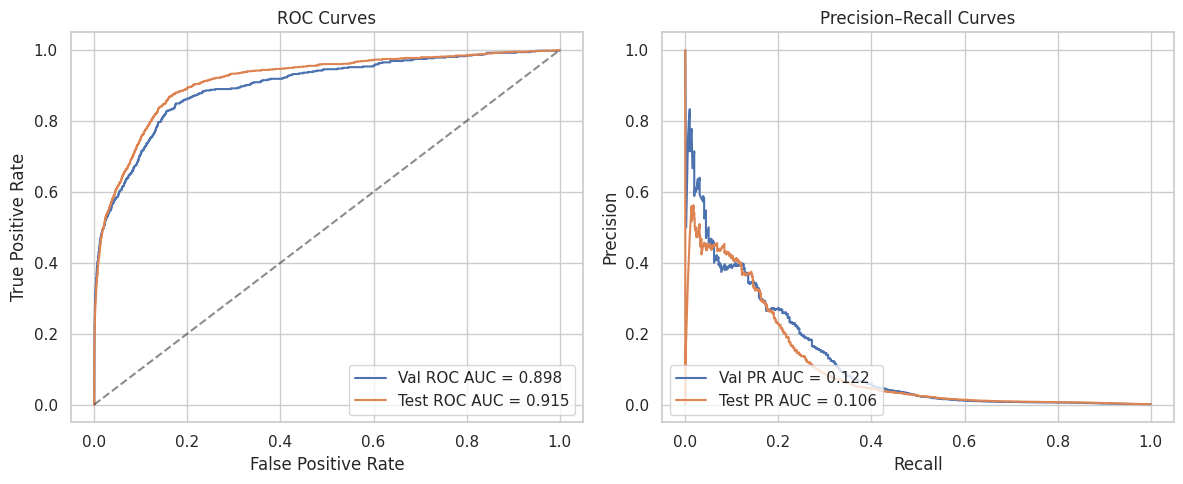

/tmp/ipykernel_1931/3617541583.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="Blues_d", ax=ax)
/tmp/ipykernel_1931/3617541583.py:57: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


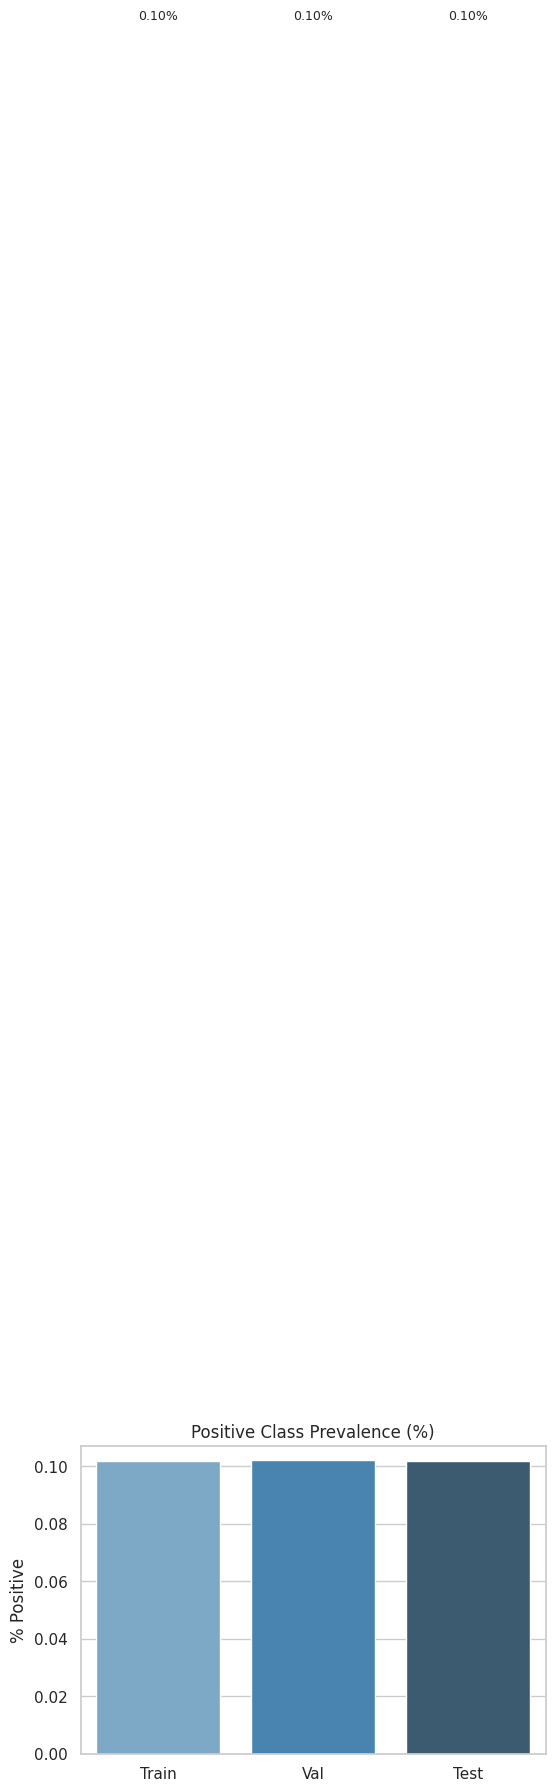

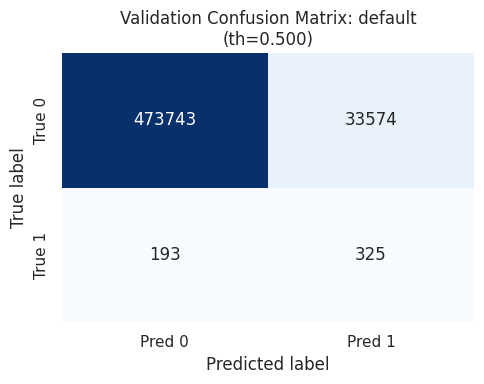

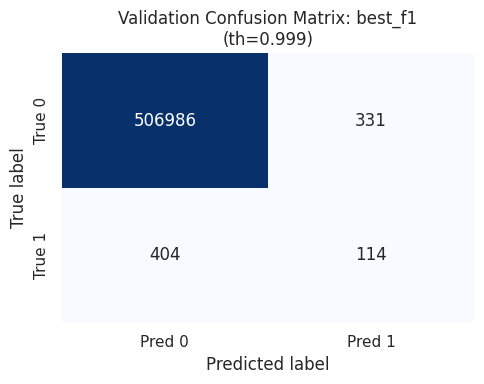

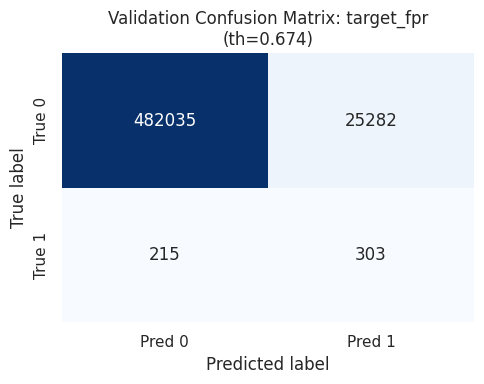

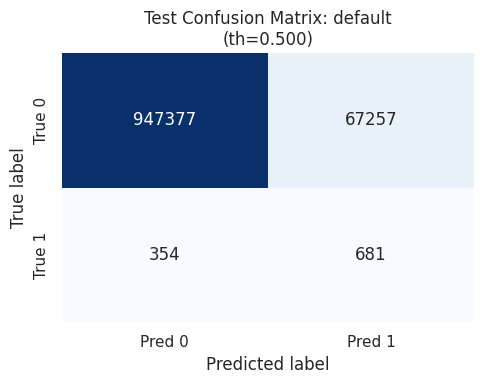

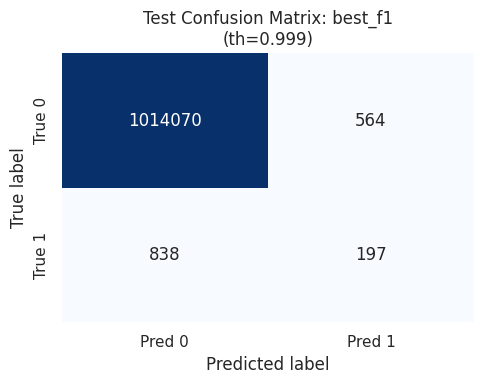

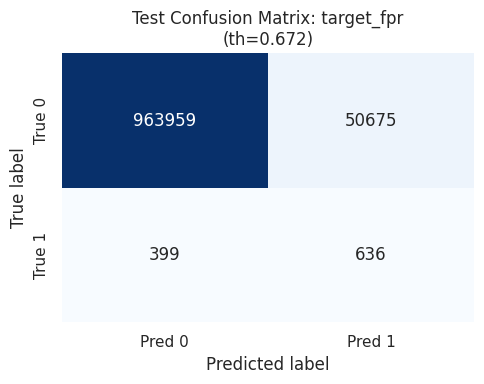

In [ ]:
# Visualization: curves, distributions, and confusion matrices
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, auc

# Ensure matplotlib styles are readable
sns.set(style="whitegrid", context="notebook")

# Collect probabilities and labels for validation and test
val_probs, val_labels = predict_proba(model, val_loader, device)
test_probs, test_labels = predict_proba(model, test_loader, device)

# Compute ROC and PR curves
val_fpr, val_tpr, _ = roc_curve(val_labels, val_probs)
val_prec, val_rec, _ = precision_recall_curve(val_labels, val_probs)
val_roc_auc = auc(val_fpr, val_tpr)
val_pr_auc = auc(val_rec, val_prec)

test_fpr, test_tpr, _ = roc_curve(test_labels, test_probs)
test_prec, test_rec, _ = precision_recall_curve(test_labels, test_probs)
test_roc_auc = auc(test_fpr, test_tpr)
test_pr_auc = auc(test_rec, test_prec)

# Figure 1: ROC and PR curves (combined)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# ROC
axes[0].plot(val_fpr, val_tpr, label=f"Val ROC AUC = {val_roc_auc:.3f}")
axes[0].plot(test_fpr, test_tpr, label=f"Test ROC AUC = {test_roc_auc:.3f}")
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_title("ROC Curves")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(loc="lower right")
# PR
axes[1].plot(val_rec, val_prec, label=f"Val PR AUC = {val_pr_auc:.3f}")
axes[1].plot(test_rec, test_prec, label=f"Test PR AUC = {test_pr_auc:.3f}")
axes[1].set_title("Precision–Recall Curves")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend(loc="lower left")
plt.tight_layout()
plt.show()

# Figure 1b: Standalone PR curves for export
# Validation PR
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(val_rec, val_prec, color="tab:blue", label=f"Val PR AUC = {val_pr_auc:.3f}")
ax.set_title("Validation Precision–Recall Curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend(loc="lower left")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# Test PR
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(test_rec, test_prec, color="tab:orange", label=f"Test PR AUC = {test_pr_auc:.3f}")
ax.set_title("Test Precision–Recall Curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend(loc="lower left")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# Figure 2: Class prevalence bars across splits (percentage positive)
train_prev = float(y_train.mean()) * 100.0
val_prev = float(y_val.mean()) * 100.0
test_prev = float(y_test.mean()) * 100.0
fig, ax = plt.subplots(figsize=(6, 4))
labels = ["Train", "Val", "Test"]
values = [train_prev, val_prev, test_prev]
sns.barplot(x=labels, y=values, palette="Blues_d", ax=ax)
ax.set_title("Positive Class Prevalence (%)")
ax.set_ylabel("% Positive")
for i, v in enumerate(values):
    ax.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Helper for confusion matrix plotting

def plot_cm(y_true: np.ndarray, y_prob: np.ndarray, threshold: float, title: str) -> None:
    preds = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, preds, labels=[0, 1])
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    ax.set_title(f"{title}\n(th={threshold:.3f})")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.tight_layout()
    plt.show()

# Choose thresholds: default, best_f1, target_fpr (if available)
val_thresholds = {k: v["threshold"] for k, v in val_metrics["thresholds"].items()}
test_thresholds = {k: v["threshold"] for k, v in test_metrics["thresholds"].items()}

chosen_keys = ["default", "best_f1"]
if "target_fpr" in val_thresholds and "target_fpr" in test_thresholds:
    chosen_keys.append("target_fpr")

# Separate figures: Confusion matrices for Validation
for key in chosen_keys:
    plot_cm(val_labels, val_probs, val_thresholds[key], f"Validation Confusion Matrix: {key}")

# Separate figures: Confusion matrices for Test
for key in chosen_keys:
    plot_cm(test_labels, test_probs, test_thresholds[key], f"Test Confusion Matrix: {key}")

# Threshold metric charts: bars for precision/recall/f1 and fpr/tnr

def plot_threshold_bars(metrics: dict, title: str) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Left: precision/recall/f1
    prf_vals = [metrics["precision"], metrics["recall"], metrics["f1"]]
    sns.barplot(x=["Precision", "Recall", "F1"], y=prf_vals, ax=axes[0], palette="Greens")
    axes[0].set_ylim(0, 1)
    axes[0].set_title(f"{title} — PRF")
    for i, v in enumerate(prf_vals):
        axes[0].text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=9)
    # Right: FPR/TNR
    fprtnt_vals = [metrics["fpr"], metrics["tnr"]]
    sns.barplot(x=["FPR", "TNR"], y=fprtnt_vals, ax=axes[1], palette="Reds")
    axes[1].set_ylim(0, 1)
    axes[1].set_title(f"{title} — FPR/TNR")
    for i, v in enumerate(fprtnt_vals):
        axes[1].text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

# Choose one threshold key to highlight (best_f1 preferred)
key_to_show = "best_f1" if "best_f1" in val_metrics["thresholds"] else "default"
plot_threshold_bars(val_metrics["thresholds"][key_to_show], f"Validation Threshold: {key_to_show}")
plot_threshold_bars(test_metrics["thresholds"][key_to_show], f"Test Threshold: {key_to_show}")
